In [2]:
# CELE

# ---------------------------------------------------------------------------------------------
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn, set_seeds, plot_loss_curves

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

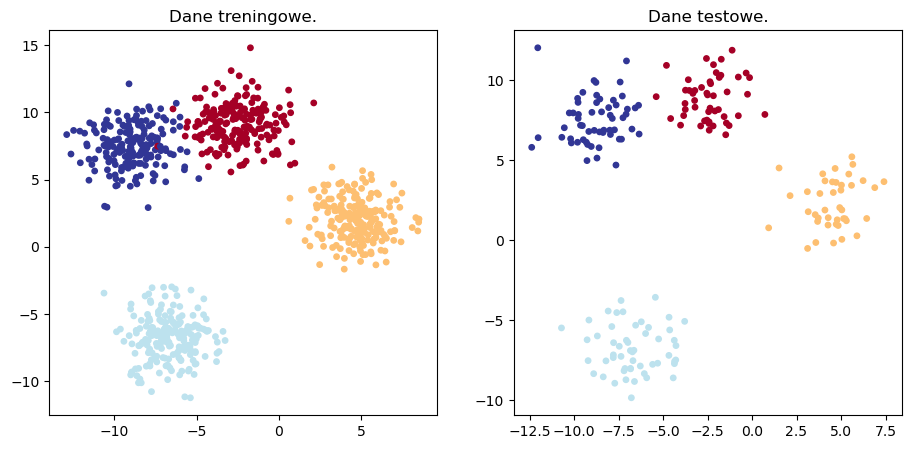

In [6]:
# dane 
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)
X = torch.tensor(X).type(torch.float32).to(device)
y = torch.tensor(y).type(torch.float32).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.title('Dane treningowe.')
plt.scatter(X_train[:,0].cpu().numpy(), X_train[:,1].cpu().numpy(), s=15, c=y_train.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.subplot(1, 2, 2)
plt.title('Dane testowe.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=y_test.cpu().numpy(), cmap=plt.cm.RdYlBu)
plt.show()

In [12]:
# klasa i model
class ModelNN(nn.Module):
    def __init__(self, input_features=1, output_features=1, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
# instancja modelu
set_seeds(42)
model = ModelNN(input_features=2, output_features=4, hidden_units=8).to(device)
model

ModelNN(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [13]:
# loss i optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

In [32]:
# przewidywania przed uczeniem
with torch.inference_mode(): 
    y_logits = model(X_test)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)
    
y_logits[:5], y_pred_probs[:5], y_pre
# plt.figure(figsize=(11, 5))
# plt.subplot(1, 2, 1)
# plt.title('Dane testowe przed uczeniem.')
# plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=15, c=(y_pred.cpu().numpy())/4, cmap=plt.cm.RdYlBu)
# plt.subplot(1, 2, 2)
# plt.title('Model przed uczeniem.')
# plot_decision_boundary(model, X_test, y_test)

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0'),
 tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989],
         [0.2118, 0.3246, 0.1889, 0.2748],
         [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0'))